# 1. Download and unzip data

In [1]:
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv

--2024-05-15 11:06:17--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 16.182.100.121, 52.217.96.148, 3.5.8.173, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|16.182.100.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘ISBI2016_ISIC_Part3_Training_Data.zip’

ISBI2016_ISIC_Part3 100%[===================>] 602.36M  12.9MB/s    in 60s     

2024-05-15 11:07:18 (10.1 MB/s) - ‘ISBI2016_ISIC_Part3_Training_Data.zip’ saved [631625308/631625308]

--2024-05-15 11:07:18--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.51.1, 54.231.172.97, 52.216.37.113, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-

In [2]:
!unzip "./ISBI2016_ISIC_Part3_Test_Data.zip"
!unzip "./ISBI2016_ISIC_Part3_Training_Data.zip"

Archive:  ./ISBI2016_ISIC_Part3_Test_Data.zip
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000012.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000013.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000014.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000015.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000020.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000022.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000023.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000027.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000036.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000037.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000040.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000043.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000052.jpg  
 extracting: ISBI2016_ISIC_Part3_Test_Data/ISIC_0000053.jpg  
 extracting: ISBI2016_IS

# 2. Make training, validation and test image folders by training and test csv files
[ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)

In [3]:
import os
import shutil
import pandas as pd
import numpy as np

if not os.path.exists("./train"):
    os.makedirs("./train")
    os.makedirs("./train/benign")
    os.makedirs("./train/malignant")
if not os.path.exists("./val"):
    os.makedirs("./val")
    os.makedirs("./val/benign")
    os.makedirs("./val/malignant")
df = pd.read_csv("./ISBI2016_ISIC_Part3_Training_GroundTruth.csv")
img_lis = []
lbl_lis = []
img_lis.append("ISIC_0000000")
lbl_lis.append("benign")
for i in range(len(df)):
    name, label = df["ISIC_0000000"][i], df["benign"][i]
    img_lis.append(name)
    lbl_lis.append(label)
N_train_val = len(img_lis)
N_train = int(N_train_val * 0.8)
print(N_train_val)
print(N_train)
shuffle_ix = np.random.permutation(np.arange(N_train_val))
ix_train = shuffle_ix[:N_train]
ix_val = shuffle_ix[N_train:]
for i in ix_train:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train/"+label+"/"+name+".jpg")
for i in ix_val:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./val/"+label+"/"+name+".jpg")

if not os.path.exists("./test"):
    os.makedirs("./test")
    os.makedirs("./test/benign")
    os.makedirs("./test/malignant")
df = pd.read_csv("./ISBI2016_ISIC_Part3_Test_GroundTruth.csv")
shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg", "./test/benign/ISIC_0000003.jpg")
for i in range(len(df)):
    name, label = df["ISIC_0000003"][i], df["0.0"][i]
    label = "benign" if label == 0 else "malignant"
    shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/"+name+".jpg", "./test/"+label+"/"+name+".jpg")


900
720


# 3. Prepare data and build dataloaders

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch

def label_statistics(train_dataset):
    cls_count = np.zeros(2).astype(np.int64)

    for i, label in train_dataset:
        cls_count[label] += 1
    return cls_count

def label_weights_for_balance(train_dataset):
    cls_count = label_statistics(train_dataset)
    labels_weight_list = []
    for i, label in train_dataset:
        weight = 1 / cls_count[label]
        labels_weight_list.append(weight)
    return labels_weight_list

root_train, root_val, root_test = './train', './val', './test'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),       # using stronger augmentation functions to enhance performance or solve LT problem
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def get_train_test_set(batch_size):
    train_dataset = ImageFolder(root_train, transform=train_transform)

    ### weighted sampling to tackle class imbalance
    weights = label_weights_for_balance(train_dataset)
    sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=650, replacement=True)
    loader_train = torch.utils.data.DataLoader(
        train_dataset, sampler=sampler_train,
        batch_size=batch_size,
    )
    # loader_train = torch.utils.data.DataLoader(
    #     dataset=train_dataset,
    #     batch_size=batch_size,
    #     shuffle=True
    #     )

    val_dataset = ImageFolder(root_val, transform=test_transform)
    loader_val = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    test_dataset = ImageFolder(root_test, transform=test_transform)
    loader_test = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    return loader_train, loader_val, loader_test

batch_size = 16
loader_train, loader_val, loader_test = get_train_test_set(batch_size)

# 4. Build the network

## Implement ResNet50

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

class Bottleneck(nn.Module):
    '''
    The single block in ResNet
    '''
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # stacking layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        '''
        Buiding ResNet layer by stacking blocks
        '''
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        if self.use_fc:
            x = F.relu(self.fc_add(x))
        if self.use_dropout:
            x = self.dropout(x)
        return x

def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)
    if pre_trained:
        pre_trained = resnet50(weights = "IMAGENET1K_V2").state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50

## Create Classification Model

In [6]:
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(ClassificationModel, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

resnet50 = get_resnet50(pre_trained=True)
model = ClassificationModel(resnet50, 1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 41.7MB/s]


### 5. Train and test your model

In [7]:

from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score
from torchvision.ops import focal_loss

torch.cuda.set_device(0)

max_epoch = 10
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


loss_list, val_loss_list = [], [] # record the training loss
auc_train_list, acc_train_list = [], [] # record the training metrics
auc_val_list, acc_val_list = [], [] # record the validation metrics

for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    ### training the model
    model.train()
    running_loss = 0.0
    train_lbl = []
    train_pred = []
    for data in tqdm(loader_train):
        optimizer.zero_grad()
        images, labels = data
        labels = labels.float()
        if use_cuda:
            images = images.cuda()
            labels = labels.float().cuda()
        outputs = model(images)[:,0]
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)
        ### focal loss
        # loss = focal_loss.sigmoid_focal_loss(outputs, labels, reduction='mean')
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_scores = list(outputs.detach().cpu().numpy())
        y_true = list(labels.detach().cpu().numpy())
        train_lbl += y_true
        train_pred += y_scores

    ### record the training loss and metrics
    # -- write your codes here
    loss = running_loss / len(loader_train)
    loss_list.append(loss)
    train_lbl, train_pred = np.array(train_lbl), np.array(train_pred)
    train_pred_lbl = np.around(train_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    train_auc = roc_auc_score(train_lbl, train_pred)
    train_acc = accuracy_score(train_lbl, train_pred_lbl)
    auc_train_list.append(train_auc)
    acc_train_list.append(train_acc)


    ### evaluate on validation set
    model.eval()
    test_lbl, test_pred = [], []
    val_loss = 0.0
    for data in loader_val:
        test_images, test_labels = data
        test_labels = test_labels.float()
        if use_cuda:
            test_images = test_images.cuda()
            test_labels = test_labels.float().cuda()
        with torch.no_grad():
            test_outputs = model(test_images)[:, 0]
        test_outputs = torch.sigmoid(test_outputs)
        y_scores = list(test_outputs.detach().cpu().numpy())
        y_true = list(test_labels.detach().cpu().numpy())
        test_lbl += y_true
        test_pred += y_scores

        v_loss = criterion(test_outputs, test_labels)
        # v_loss = focal_loss.sigmoid_focal_loss(test_outputs, test_labels, reduction='mean')
        val_loss += v_loss.item()

    ### record the validation loss and metrics, save the best checkpoint
    test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
    test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    test_auc = roc_auc_score(test_lbl, test_pred)
    test_acc = accuracy_score(test_lbl, test_pred_lbl)
    auc_val_list.append(test_auc)
    acc_val_list.append(test_acc)
    val_loss = val_loss / len(loader_val)
    val_loss_list.append(val_loss)
    print(loss, val_loss, train_auc, test_auc)


### evaluate on test set
model.eval()
test_lbl, test_pred = [], []
for data in loader_val:
    test_images, test_labels = data
    test_labels = test_labels.float()
    if use_cuda:
        test_images = test_images.cuda()
        test_labels = test_labels.float().cuda()
    test_outputs = model(test_images)[:, 0]
    test_outputs = torch.sigmoid(test_outputs)
    y_scores = list(test_outputs.detach().cpu().numpy())
    y_true = list(test_labels.detach().cpu().numpy())
    test_lbl += y_true
    test_pred += y_scores

### compute and print the metrics on test set
test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
test_auc = roc_auc_score(test_lbl, test_pred)
test_acc = accuracy_score(test_lbl, test_pred_lbl)
print(test_auc, test_acc)

 -- Epoch 1/10


100%|██████████| 41/41 [00:35<00:00,  1.14it/s]


0.6700703610734242 0.468089592953523 0.6160511363636363 0.7630942788074134
 -- Epoch 2/10


100%|██████████| 41/41 [00:34<00:00,  1.19it/s]


0.6200261079683537 0.461024379512916 0.717649846008055 0.7590652699435939
 -- Epoch 3/10


100%|██████████| 41/41 [00:38<00:00,  1.07it/s]


0.6085359875748797 0.527555854835858 0.7206857142857143 0.7078968573730862
 -- Epoch 4/10


100%|██████████| 41/41 [00:35<00:00,  1.16it/s]


0.6177920640968695 0.5215075615172585 0.7011549840691853 0.73348106365834
 -- Epoch 5/10


100%|██████████| 41/41 [00:34<00:00,  1.18it/s]


0.5962504555539387 0.5498958996031433 0.7218624555025372 0.7375100725221595
 -- Epoch 6/10


100%|██████████| 41/41 [00:33<00:00,  1.23it/s]


0.5709801018238068 0.515044257704479 0.7651714285714285 0.7717566478646253
 -- Epoch 7/10


100%|██████████| 41/41 [00:29<00:00,  1.37it/s]


0.5693509629586848 0.5571906745123366 0.761607202848888 0.7757856567284448
 -- Epoch 8/10


100%|██████████| 41/41 [00:39<00:00,  1.04it/s]


0.5627046169304266 0.7017347461854418 0.7775523554004986 0.6968170829975826
 -- Epoch 9/10


100%|██████████| 41/41 [00:31<00:00,  1.31it/s]


0.5519838638421966 0.5820347610861063 0.7873999297252637 0.717365028203062
 -- Epoch 10/10


100%|██████████| 41/41 [00:39<00:00,  1.03it/s]


0.5492176333578621 0.8074494018219411 0.7844141554980129 0.7632957292506044
0.7632957292506044 0.6111111111111112


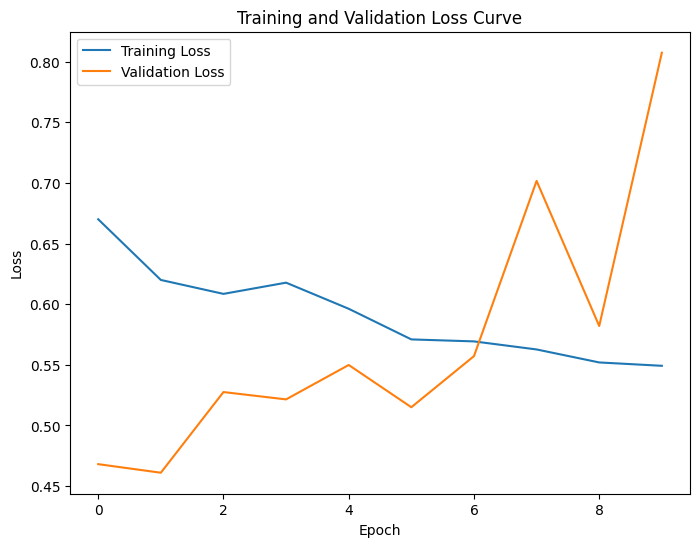

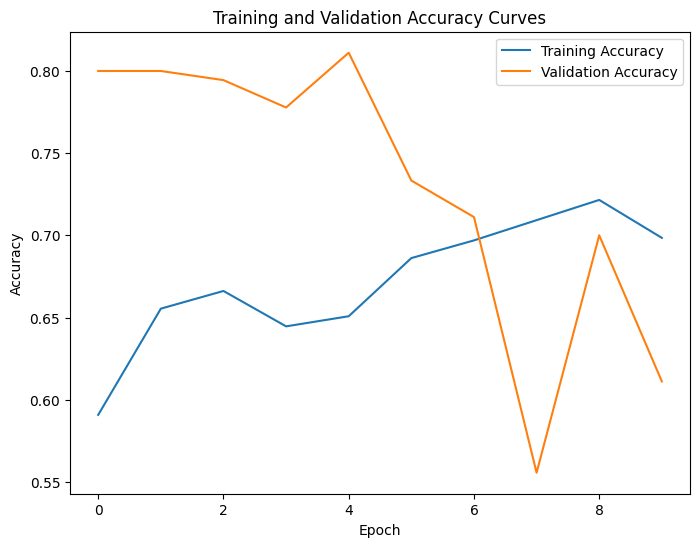

In [8]:
import matplotlib.pyplot as plt

# Plotting the training loss curve
plt.figure(figsize=(8, 6))
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

# Plotting the training and testing accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(acc_train_list, label='Training Accuracy')
plt.plot(acc_val_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()

# New appraoch: also train the unlabeled data labeled with pseudo labeled

## download new unlabeled dataset

In [9]:
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
!unzip "./ISBI2016_ISIC_Part1_Training_Data.zip"

--2024-05-15 11:16:42--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.165.153, 52.216.96.179, 52.216.215.1, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.165.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘ISBI2016_ISIC_Part1_Training_Data.zip’

ISBI2016_ISIC_Part1 100%[===================>] 602.36M  13.3MB/s    in 48s     

2024-05-15 11:17:31 (12.6 MB/s) - ‘ISBI2016_ISIC_Part1_Training_Data.zip’ saved [631625308/631625308]

Archive:  ./ISBI2016_ISIC_Part1_Training_Data.zip
 extracting: ISBI2016_ISIC_Part1_Training_Data/ISIC_0000000.jpg  
 extracting: ISBI2016_ISIC_Part1_Training_Data/ISIC_0000001.jpg  
 extracting: ISBI2016_ISIC_Part1_Training_Data/ISIC_0000002.jpg  
 extracting: ISBI2016_ISIC_Part1_Training_Data/ISIC

## rename image

In [10]:
import os

folder_path = '/content/ISBI2016_ISIC_Part1_Training_Data'
new_prefix = 'new_'

# Get the list of files in the folder
file_list = os.listdir(folder_path)

# Iterate over the files
for filename in file_list:
    if filename.endswith('.jpg'):
        # Generate the new filename
        new_filename = new_prefix + filename

        # Rename the file
        original_path = os.path.join(folder_path, filename)
        new_path = os.path.join(folder_path, new_filename)
        os.rename(original_path, new_path)

        print(f"Renamed '{filename}' to '{new_filename}'")

Renamed 'ISIC_0009884.jpg' to 'new_ISIC_0009884.jpg'
Renamed 'ISIC_0009991.jpg' to 'new_ISIC_0009991.jpg'
Renamed 'ISIC_0010056.jpg' to 'new_ISIC_0010056.jpg'
Renamed 'ISIC_0010032.jpg' to 'new_ISIC_0010032.jpg'
Renamed 'ISIC_0009939.jpg' to 'new_ISIC_0009939.jpg'
Renamed 'ISIC_0010352.jpg' to 'new_ISIC_0010352.jpg'
Renamed 'ISIC_0000511.jpg' to 'new_ISIC_0000511.jpg'
Renamed 'ISIC_0000475.jpg' to 'new_ISIC_0000475.jpg'
Renamed 'ISIC_0000031.jpg' to 'new_ISIC_0000031.jpg'
Renamed 'ISIC_0000118.jpg' to 'new_ISIC_0000118.jpg'
Renamed 'ISIC_0009951.jpg' to 'new_ISIC_0009951.jpg'
Renamed 'ISIC_0010318.jpg' to 'new_ISIC_0010318.jpg'
Renamed 'ISIC_0010586.jpg' to 'new_ISIC_0010586.jpg'
Renamed 'ISIC_0002459.jpg' to 'new_ISIC_0002459.jpg'
Renamed 'ISIC_0009297.jpg' to 'new_ISIC_0009297.jpg'
Renamed 'ISIC_0005787.jpg' to 'new_ISIC_0005787.jpg'
Renamed 'ISIC_0000301.jpg' to 'new_ISIC_0000301.jpg'
Renamed 'ISIC_0010080.jpg' to 'new_ISIC_0010080.jpg'
Renamed 'ISIC_0010858.jpg' to 'new_ISIC_001085

## get pseudo label and copy to train folder

In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os

model.eval()
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

import shutil

image_folder = '/content/ISBI2016_ISIC_Part1_Training_Data'
benign_folder = '/content/train/benign'
malignant_folder = '/content/train/malignant'

# Create the target folders if they don't exist
os.makedirs(benign_folder, exist_ok=True)
os.makedirs(malignant_folder, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if GPU is available

image_files = os.listdir(image_folder)  # Get the list of image files

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)

    # Open and transform the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)

    # Move the input tensor to the GPU
    image = image.to(device)

    # Move the model to the GPU if available
    model = model.to(device)

    # Perform prediction
    with torch.no_grad():
        output = model(image)

    # Move the output tensor back to the CPU if necessary
    output = output.cpu()

    # Process the output as required
    predicted_class = output.argmax(dim=1).item()

    # Print the predicted class
    print(f"Image: {image_file}, Predicted Class: {predicted_class}")

    # Copy the image to the appropriate folder based on the predicted class
    if predicted_class == 0:
        shutil.copy(image_path, os.path.join(benign_folder, image_file))
        print(f"Copied image '{image_file}' to '{benign_folder}'")
    elif predicted_class == 1:
        shutil.copy(image_path, os.path.join(malignant_folder, image_file))
        print(f"Copied image '{image_file}' to '{malignant_folder}'")

Image: new_ISIC_0005247.jpg, Predicted Class: 0
Copied image 'new_ISIC_0005247.jpg' to '/content/train/benign'
Image: new_ISIC_0010334.jpg, Predicted Class: 0
Copied image 'new_ISIC_0010334.jpg' to '/content/train/benign'
Image: new_ISIC_0000087.jpg, Predicted Class: 0
Copied image 'new_ISIC_0000087.jpg' to '/content/train/benign'
Image: new_ISIC_0000019.jpg, Predicted Class: 0
Copied image 'new_ISIC_0000019.jpg' to '/content/train/benign'
Image: new_ISIC_0000541.jpg, Predicted Class: 0
Copied image 'new_ISIC_0000541.jpg' to '/content/train/benign'
Image: new_ISIC_0010581.jpg, Predicted Class: 0
Copied image 'new_ISIC_0010581.jpg' to '/content/train/benign'
Image: new_ISIC_0005666.jpg, Predicted Class: 0
Copied image 'new_ISIC_0005666.jpg' to '/content/train/benign'
Image: new_ISIC_0008280.jpg, Predicted Class: 0
Copied image 'new_ISIC_0008280.jpg' to '/content/train/benign'
Image: new_ISIC_0000345.jpg, Predicted Class: 0
Copied image 'new_ISIC_0000345.jpg' to '/content/train/benign'
I

## update loader_train

In [12]:
train_dataset = ImageFolder(root_train, transform=train_transform)

loader_train = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
    )

## train the model again with pseudo labeled data with smaller learning rate

In [13]:

from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score
from torchvision.ops import focal_loss

torch.cuda.set_device(0)

max_epoch = 10
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)


loss_list, val_loss_list = [], [] # record the training loss
auc_train_list, acc_train_list = [], [] # record the training metrics
auc_val_list, acc_val_list = [], [] # record the validation metrics

for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    ### training the model
    model.train()
    running_loss = 0.0
    train_lbl = []
    train_pred = []
    for data in tqdm(loader_train):
        optimizer.zero_grad()
        images, labels = data
        labels = labels.float()
        if use_cuda:
            images = images.cuda()
            labels = labels.float().cuda()
        outputs = model(images)[:,0]
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)
        ### focal loss
        # loss = focal_loss.sigmoid_focal_loss(outputs, labels, reduction='mean')
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_scores = list(outputs.detach().cpu().numpy())
        y_true = list(labels.detach().cpu().numpy())
        train_lbl += y_true
        train_pred += y_scores

    ### record the training loss and metrics
    # -- write your codes here
    loss = running_loss / len(loader_train)
    loss_list.append(loss)
    train_lbl, train_pred = np.array(train_lbl), np.array(train_pred)
    train_pred_lbl = np.around(train_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    train_auc = roc_auc_score(train_lbl, train_pred)
    train_acc = accuracy_score(train_lbl, train_pred_lbl)
    auc_train_list.append(train_auc)
    acc_train_list.append(train_acc)


    ### evaluate on validation set
    model.eval()
    test_lbl, test_pred = [], []
    val_loss = 0.0
    for data in loader_val:
        test_images, test_labels = data
        test_labels = test_labels.float()
        if use_cuda:
            test_images = test_images.cuda()
            test_labels = test_labels.float().cuda()
        with torch.no_grad():
            test_outputs = model(test_images)[:, 0]
        test_outputs = torch.sigmoid(test_outputs)
        y_scores = list(test_outputs.detach().cpu().numpy())
        y_true = list(test_labels.detach().cpu().numpy())
        test_lbl += y_true
        test_pred += y_scores

        v_loss = criterion(test_outputs, test_labels)
        # v_loss = focal_loss.sigmoid_focal_loss(test_outputs, test_labels, reduction='mean')
        val_loss += v_loss.item()

    ### record the validation loss and metrics, save the best checkpoint
    test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
    test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    test_auc = roc_auc_score(test_lbl, test_pred)
    test_acc = accuracy_score(test_lbl, test_pred_lbl)
    auc_val_list.append(test_auc)
    acc_val_list.append(test_acc)
    val_loss = val_loss / len(loader_val)
    val_loss_list.append(val_loss)
    print(loss, val_loss, train_auc, test_auc)


### evaluate on test set
model.eval()
test_lbl, test_pred = [], []
for data in loader_val:
    test_images, test_labels = data
    test_labels = test_labels.float()
    if use_cuda:
        test_images = test_images.cuda()
        test_labels = test_labels.float().cuda()
    test_outputs = model(test_images)[:, 0]
    test_outputs = torch.sigmoid(test_outputs)
    y_scores = list(test_outputs.detach().cpu().numpy())
    y_true = list(test_labels.detach().cpu().numpy())
    test_lbl += y_true
    test_pred += y_scores

### compute and print the metrics on test set
test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
test_auc = roc_auc_score(test_lbl, test_pred)
test_acc = accuracy_score(test_lbl, test_pred_lbl)
print(test_auc, test_acc)

 -- Epoch 1/10


100%|██████████| 102/102 [01:31<00:00,  1.11it/s]


0.312552353330687 0.7191130837891251 0.69015199724083 0.717767929089444
 -- Epoch 2/10


100%|██████████| 102/102 [01:28<00:00,  1.15it/s]


0.26430901264150936 0.6073394106739821 0.7332543148465698 0.7469782433521353
 -- Epoch 3/10


100%|██████████| 102/102 [01:28<00:00,  1.16it/s]


0.2534217547040944 0.6300749542036405 0.77512763590613 0.717163577759871
 -- Epoch 4/10


100%|██████████| 102/102 [01:28<00:00,  1.15it/s]


0.23851008358977588 0.6606699686963111 0.8129156364307609 0.7465753424657535
 -- Epoch 5/10


100%|██████████| 102/102 [01:30<00:00,  1.13it/s]


0.24484729219008894 0.5895538709204023 0.806090576559684 0.7528203062046736
 -- Epoch 6/10


100%|██████████| 102/102 [01:26<00:00,  1.17it/s]


0.23314281962081498 0.664583784081818 0.8303936189333475 0.7445608380338438
 -- Epoch 7/10


100%|██████████| 102/102 [01:26<00:00,  1.18it/s]


0.24424098030317062 0.5380811036350982 0.8024084446150036 0.782232070910556
 -- Epoch 8/10


100%|██████████| 102/102 [01:28<00:00,  1.15it/s]


0.2500363215073651 0.5111616532570528 0.7866403703505799 0.7747784045124899
 -- Epoch 9/10


100%|██████████| 102/102 [01:26<00:00,  1.18it/s]


0.24490764094334022 0.5674106558047546 0.8137025828358245 0.7606768734891216
 -- Epoch 10/10


100%|██████████| 102/102 [01:27<00:00,  1.17it/s]


0.24764034327338724 0.5202140380473187 0.8066054921086764 0.765914585012087
0.765914585012087 0.8111111111111111


## plot new graph

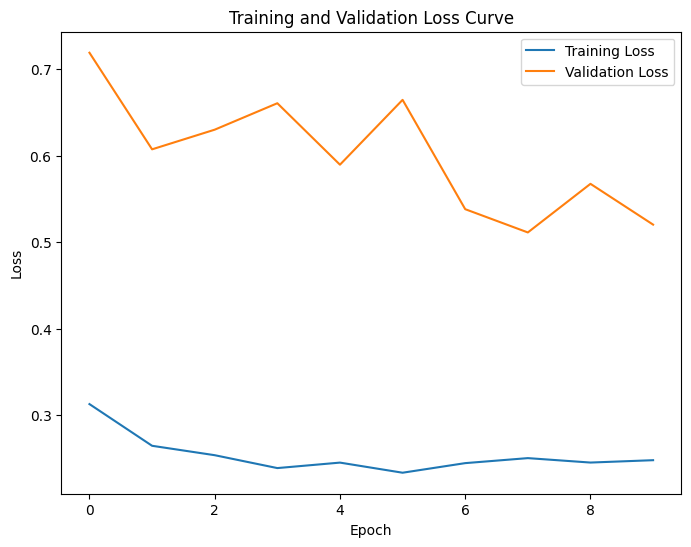

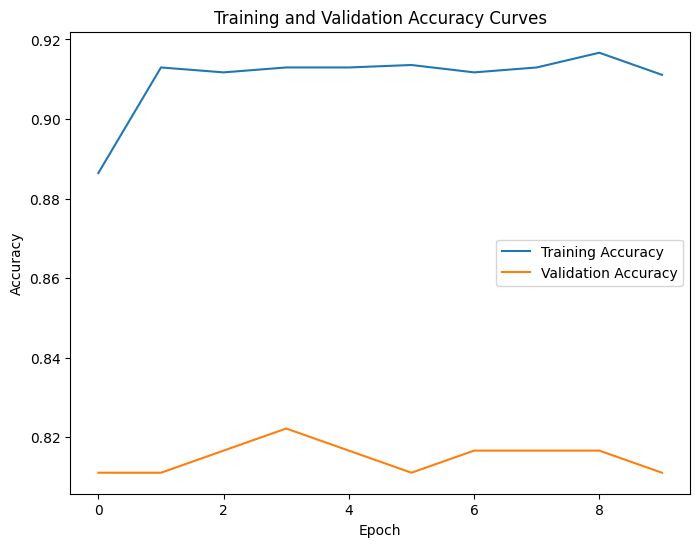

In [14]:
import matplotlib.pyplot as plt

# Plotting the training loss curve
plt.figure(figsize=(8, 6))
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

# Plotting the training and testing accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(acc_train_list, label='Training Accuracy')
plt.plot(acc_val_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()